# Clustering

- What is clustering? Identifying groups in our data.
- Why might we do clustering?
    - Exploration
    - Labeling
    - Features for Supervised Learning
- KMeans Algorithm
    1. Start with `k` random points
    1. Assign every observation to the closest centroids.
    1. Recalculate centroids
    1. Repeat

## Example 1: Mall Customers

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

import wrangle_mall

In [2]:
customers = wrangle_mall.acquire()
train, validate, test = wrangle_mall.split(customers)
train_scaled, _, _ = wrangle_mall.scale(train, validate, test)

Train: 136 rows, 5 cols
Validate: 34 rows, 5 cols
Test: 30 rows, 5 cols


### Cluster

1. choose features to cluster on
1. choose k
1. create and fit the model

In [3]:
cols = ['spending_score', 'annual_income']
X = train_scaled[cols]
kmeans = KMeans(n_clusters=5).fit(X)

1. Look at the model's output
1. interpretation
1. visualize

In [4]:
# NB. clusters were created on scaled data, but can be used to analyze unscaled
train['cluster'] = kmeans.predict(X)
train.cluster = train.cluster.astype('category')
train.head()

,customer_id,gender,age,annual_income,spending_score,cluster
32,33,Male,53,33,4,4
186,187,Female,54,101,24,1
77,78,Male,40,54,48,3
33,34,Male,18,33,92,0
58,59,Female,27,46,51,3


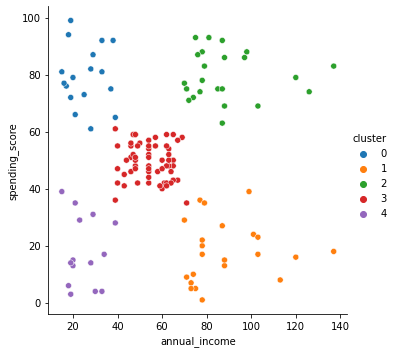

In [5]:
sns.relplot(data=train, y='spending_score', x='annual_income', hue='cluster')

In [12]:
train.groupby('cluster').mean()

,customer_id,age,annual_income,spending_score
cluster,,,,
0,22.470588,24.764706,25.588235,79.529412
1,163.000000,40.909091,88.318182,18.000000
2,164.782609,32.173913,88.434783,79.565217
3,84.650000,42.483333,54.633333,49.466667
4,20.857143,47.500000,24.857143,18.000000


### Example: Clusters for Supervised Model

1. Do clustering
1. Build a model with the *just* the produced clusters
1. Look at the coefficients of the resulting model to determine which clusters are most important (most impactful on the model's predictions)
1. Use the most impactful clusters in combination with other features

In [15]:
from sklearn.linear_model import LinearRegression

In [13]:
cols = ['age', 'annual_income']
X = train_scaled[cols]
kmeans = KMeans(n_clusters=5).fit(X)

In [19]:
train['cluster'] = kmeans.predict(X)

cluster_df = pd.get_dummies(train.cluster)
cluster_df.columns = [f'cluster_{n}' for n in cluster_df]
cluster_df.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
32,0,0,1,0,0
186,0,0,0,1,0
77,0,0,0,1,0
33,0,0,0,0,1
58,1,0,0,0,0


In [20]:
X = cluster_df
y = train.spending_score

lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.2038005486859199

In [23]:
lr.intercept_

-9412644867965664.0

In [25]:
pd.options.display.float_format = '{:15.2f}'.format

In [27]:
pd.Series(lr.coef_, index=X.columns).sort_values()

cluster_3   9412644867965702.00
cluster_0   9412644867965704.00
cluster_2   9412644867965706.00
cluster_1   9412644867965724.00
cluster_4   9412644867965728.00
dtype: float64

In [29]:
train['is_cluster_4'] = train['cluster'] == 4

In [30]:
X = train[['age', 'annual_income', 'is_cluster_4']]
y = train.spending_score

lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.1702897918792935

Takeaway:

- Adding cluster 4 was not helpful in our model
- When using clustering for supervised learning, we could use clusters based on independent variables in place of those variables
    - Ex. cluster on x1, x2, analyze clusters, build a model with clusters and x3 to predict y
    - Ex. cluster on bedroom count and bathroom count, use those clusers in combination with square footage to predict home value

### How do we choose a value for k?

It's a judgement call

- domain knowledge
- educated guesses
- the elbow method
    - **inertia**: sum of squared distance from each point to its centroid

Elbow Method Demo

1. Choose a range of k values
1. Create a model for each k and record **inertia**
1. Visualize results (k vs inertia)

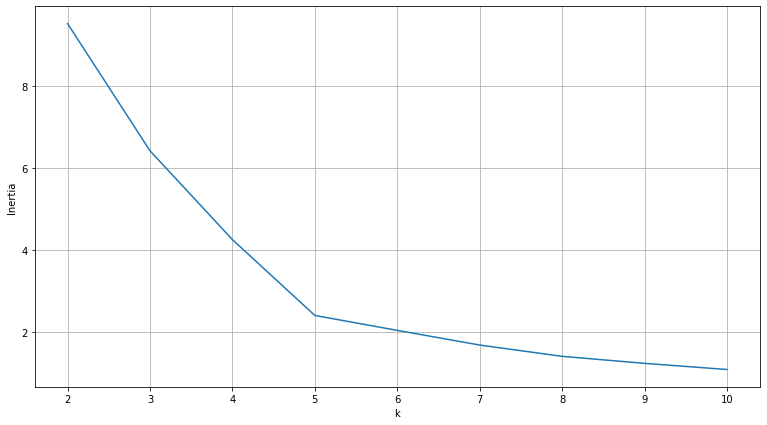

In [11]:
cols = ['spending_score', 'annual_income']
X = train_scaled[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

## Example 2: Insurance Data

### Setup

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('https://gist.githubusercontent.com/zgulde/ad9305acb30b00f768d4541a41f5ba19/raw/01f4ac8f158e68b0d293ff726c0c1dd08cdd501d/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,3,16884.92
1,18,1,33.77,1,0,2,1725.55
2,28,1,33.00,3,0,2,4449.46
3,33,1,22.70,0,0,1,21984.47
4,32,1,28.88,0,0,1,3866.86


In [33]:
# data split
train_and_validate, test = train_test_split(df, test_size=.1, random_state=123)
train, validate = train_test_split(train_and_validate, test_size=.1, random_state=123)

# scale
scaler = MinMaxScaler()
cols = ['age', 'bmi', 'children', 'charges']
train_scaled = train.copy()
train_scaled[cols] = scaler.fit_transform(train[cols])

### Cluster

1. Choose a k
1. Create the model and produce clusters
1. Interpret results

In [39]:
X = train_scaled[cols]
kmeans = KMeans(n_clusters=4).fit(X)
train['cluster'] = kmeans.predict(X)
train.cluster = train.cluster.astype('category')

In [40]:
train.head()

,age,sex,bmi,children,smoker,region,charges,cluster
88,46,0,27.74,0,0,1,8026.67,3
137,22,1,25.18,0,0,1,2045.69,0
316,50,1,32.20,0,0,1,8835.26,3
87,56,0,27.20,0,0,3,11073.18,3
80,31,1,26.89,1,0,0,4441.21,0


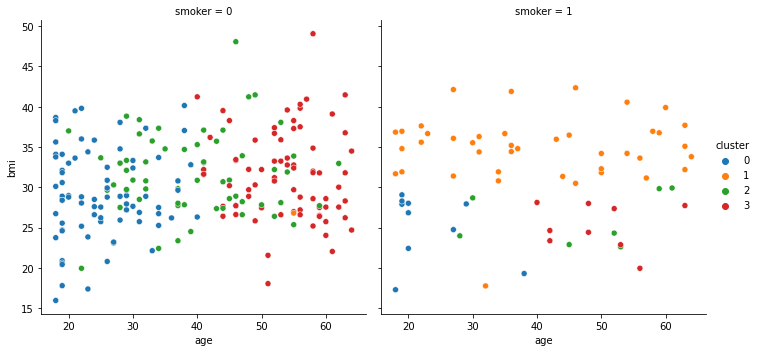

In [43]:
sns.relplot(data=train, y='bmi', x='age', hue='cluster', col='smoker')

In [44]:
# clustering based on 'age', 'bmi', 'children', and 'charges'
train.groupby('cluster').mean()

,age,sex,bmi,children,smoker,region,charges
cluster,,,,,,,
0,25.00,0.49,28.73,0.52,0.11,1.54,5191.40
1,40.31,0.69,34.65,1.12,0.98,1.64,40608.01
2,40.00,0.48,31.06,2.73,0.10,1.48,11533.44
3,53.14,0.49,30.89,0.48,0.11,1.40,12506.03


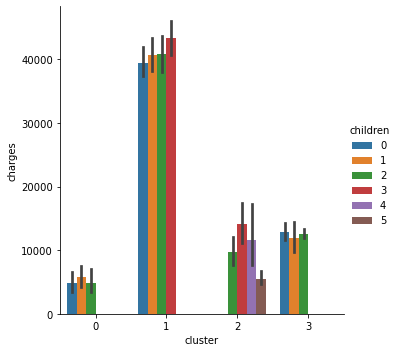

In [48]:
sns.catplot(data=train, hue='children', y='charges', x='cluster', kind='bar')